In [224]:
import numpy as np
import math
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

sns.set(
    { "figure.figsize": (17, 7) },
    style='ticks',
    palette=sns.color_palette("Set2"),
    color_codes=True,
    font_scale=0.8
)
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

In [225]:
# Load your dataset
auto = pd.read_csv('adverts.csv')
auto.columns

Index(['public_reference', 'mileage', 'reg_code', 'standard_colour',
       'standard_make', 'standard_model', 'vehicle_condition',
       'year_of_registration', 'price', 'body_type', 'crossover_car_and_van',
       'fuel_type'],
      dtype='object')

In [226]:
# Drop unneeded 
auto.drop(columns=["public_reference", "standard_colour"], inplace=True)

In [227]:
auto["year_of_registration"].mask(auto["year_of_registration"] < 1905, inplace=True)

In [228]:
auto["year_of_registration"].unique()

array([  nan, 2011., 2017., 2016., 2015., 2013., 2008., 2019., 2010.,
       2012., 2018., 2009., 1984., 2014., 2003., 2006., 2020., 2005.,
       2000., 2002., 2007., 2004., 1991., 2001., 1986., 1998., 1990.,
       1993., 1987., 1994., 1999., 1970., 1988., 1995., 1997., 1969.,
       1992., 1989., 1996., 1976., 1983., 1980., 1973., 1962., 1967.,
       1972., 1982., 1968., 1979., 1964., 1933., 1981., 1985., 1978.,
       1971., 1974., 1966., 1977., 1961., 1965., 1957., 1963., 1954.,
       1975., 1955., 1960., 1956., 1959., 1909., 1934., 1958., 1950.,
       1952.])

In [229]:
for col in auto.columns:
    print(f"{col} has {auto[col].isnull().sum()} null values")

mileage has 127 null values
reg_code has 31857 null values
standard_make has 0 null values
standard_model has 0 null values
vehicle_condition has 0 null values
year_of_registration has 33328 null values
price has 0 null values
body_type has 837 null values
crossover_car_and_van has 0 null values
fuel_type has 601 null values


## Ideas

Mileage - Can be estimated based on the age and type of the car

Reg Codes - Can be dropped once the info has been added to year_of_reg

Year of reg - Get some from reg_code, other can be estimated from either: median of all values or imputed from similar cars in the dataset. 

Body type - Impute from data, manual lookup or the highly cursed: "just call chatgpt lmao"

Fuel type - Just assume it is petrol as that is by far the most common. <--- Check that with some analysis (maybe it differs for some brands?)

In [230]:
# Seems unlikely that a 2013 Vauxhall Astra with exactly 999999.0 miles on it

auto["miles_per_day"] = auto["mileage"] / ((2020 -auto["year_of_registration"]) * 365)

auto.loc[(auto["miles_per_day"] > 300) & (auto["miles_per_day"] < np.inf)]

,mileage,reg_code,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,miles_per_day
14337,114730.0,69,Land Rover,Discovery,USED,2019.0,52844,SUV,False,Diesel,314.328767
43974,999999.0,63,Vauxhall,Astra,USED,2013.0,9999,Hatchback,False,Diesel,391.389041
115277,740000.0,14,Volvo,XC90,USED,2014.0,14795,SUV,False,Diesel,337.899543
117319,242000.0,19,Honda,Civic,USED,2019.0,15500,Hatchback,False,Diesel,663.013699
131508,788072.0,68,MINI,Countryman,USED,2018.0,22875,SUV,False,Petrol,1079.550685
281160,195668.0,P,Buick,Riviera,USED,2019.0,7500,Saloon,False,Petrol,536.076712


In [231]:
# Seems unlikely that there's a 2012 Fiat 500 kicking about with 0 miles on it being traded in 
auto.loc[(auto["mileage"] < 10) & (auto["vehicle_condition"] != "NEW") & (auto["year_of_registration"] < 2018)].head(10)

,mileage,reg_code,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,miles_per_day
1656,0.0,13,Vauxhall,Insignia,USED,2013.0,2975,Hatchback,False,Diesel,0.0
2754,0.0,63,Audi,A1,USED,2013.0,8000,Hatchback,False,Diesel,0.0
8677,0.0,D,Porsche,911,USED,1987.0,89995,Convertible,False,Petrol,0.0
17265,0.0,65,Renault,Kadjar,USED,2015.0,10699,SUV,False,Diesel,0.0
52682,0.0,61,BMW,X6,USED,2011.0,14000,SUV,False,Diesel,0.0
67889,0.0,15,Kia,Venga,USED,2015.0,6699,MPV,False,Petrol,0.0
77011,0.0,W,Porsche,911,USED,1981.0,130000,Coupe,False,Petrol,0.0
92881,0.0,V,Honda,Civic,USED,1999.0,1496,Hatchback,False,Petrol,0.0
122534,0.0,C,Land Rover,Defender 110,USED,1986.0,89995,SUV,False,Petrol,0.0
132740,0.0,66,Volkswagen,up!,USED,2016.0,7995,Hatchback,False,Petrol,0.0


In [232]:
auto.loc[(auto["mileage"] < 10) & (auto["vehicle_condition"] != "NEW") & (auto["year_of_registration"] < 2018)].replace(0, np.nan, inplace=True)

In [233]:
auto.loc[auto["vehicle_condition"] == "USED"]["mileage"].mode()

0    10.0
Name: mileage, dtype: float64

<Axes: xlabel='mileage', ylabel='Count'>

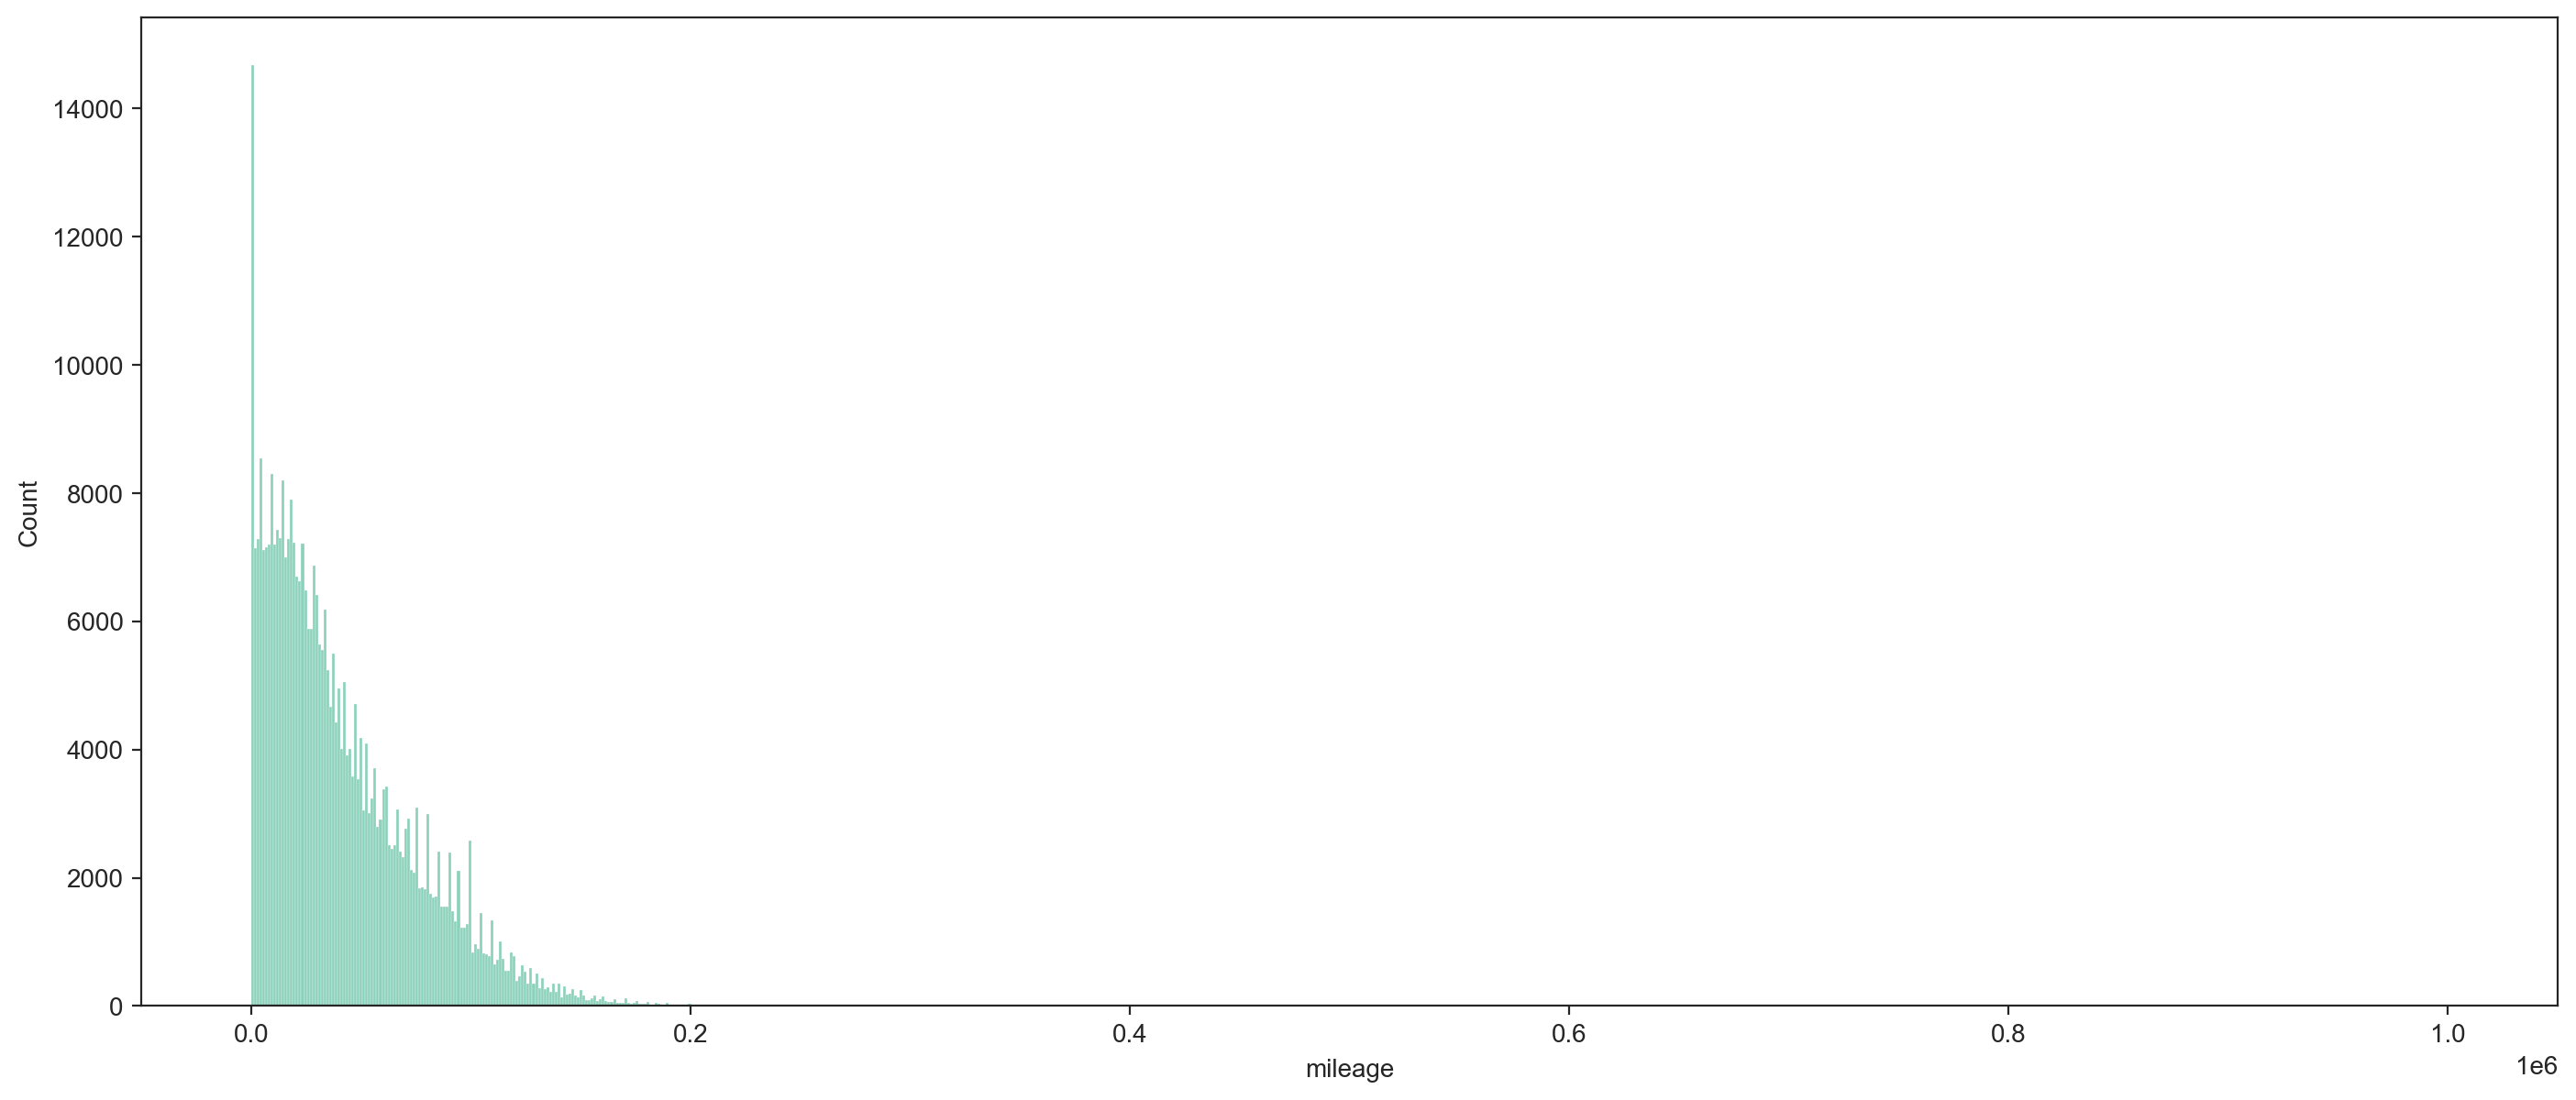

In [234]:
sns.histplot(auto.loc[auto["vehicle_condition"] == "USED"], x="mileage")

In [235]:
# Check that all new cars have the year of reg filled as 2020
new_no_year = auto.loc[auto["year_of_registration"].isna() & (auto["vehicle_condition"] == "NEW")]
new_no_year["year_of_registration"] = new_no_year["year_of_registration"].map(lambda f: 2020)
auto.loc[auto["year_of_registration"].isna() & (auto["vehicle_condition"] == "NEW")] = new_no_year

In [236]:
auto["reg_code"].unique()

array([nan, '61', '17', '16', '64', '13', '08', '19', '60', '69', '66',
       '12', '18', '65', '09', 'B', '10', '14', '03', '67', '63', '15',
       '68', '56', '20', '70', '62', '11', '05', '59', '58', 'W', '02',
       '57', '06', '52', '53', '04', 'J', '07', '55', '51', 'X', 'D', 'S',
       'Y', '54', 'H', 'K', 'E', 'L', 'V', 'M', 'G', 'T', 'N', 'P', 'A',
       'F', 'R', 'C', '94', '85', 'CA', 'm', 'FW', '723xuu', '95', 's',
       '38', 'k', '37', 'p'], dtype=object)

In [237]:
auto.loc[auto["year_of_registration"].isnull() & auto["reg_code"].notnull()]

,mileage,reg_code,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,miles_per_day
54,30000.0,18,Vauxhall,Insignia,USED,NaN,11990,Hatchback,False,Petrol,NaN
83,42847.0,61,Honda,Jazz,USED,NaN,5695,Hatchback,False,Petrol,NaN
865,43130.0,66,Land Rover,Range Rover Sport,USED,NaN,35990,SUV,False,Diesel,NaN
968,63369.0,17,SKODA,Rapid Spaceback,USED,NaN,7490,Hatchback,False,Diesel,NaN
1256,18715.0,68,Volvo,V40,USED,NaN,16950,NaN,False,Petrol,NaN
...,...,...,...,...,...,...,...,...,...,...,...
400336,66287.0,63,Vauxhall,Astra GTC,USED,NaN,8400,Coupe,False,Petrol,NaN
400725,45.0,20,Land Rover,Range Rover Evoque,USED,NaN,46945,SUV,False,Diesel,NaN
401314,12522.0,67,Dacia,Sandero,USED,NaN,6300,Hatchback,False,Petrol,NaN
401323,46000.0,13,Volkswagen,Caravelle,USED,NaN,22995,MPV,False,Diesel,NaN


In [238]:
def reg_to_year(reg_code):
    try:
        if math.isnan(reg_code): return np.nan
        reg_code = int(reg_code)
    except:
        letters = "ABCDEFGHJKLMNPRSTXYZ"

        if reg_code not in letters: return np.nan
        match reg_code:
            case "V":
                return 1999
            case "W":
                return 2000
        return 1983 + letters.find(reg_code)
    
    if reg_code > 71: return np.nan

    if reg_code < 50:
        if reg_code > 20: return np.nan
        return reg_code + 2000
    
    return reg_code + 1950

auto["reg_code"] = auto["reg_code"].map(reg_to_year)
auto["year_of_registration"].fillna(auto["reg_code"], inplace=True)
auto["year_of_registration"].unique()

array([2020., 2011., 2017., 2016., 2015., 2013., 2008., 2019., 2010.,
       2012., 2018., 2009., 1984., 2014., 2003.,   nan, 2006., 2005.,
       2000., 2002., 2007., 2004., 1991., 2001., 1986., 1998., 1990.,
       1993., 1987., 1994., 1999., 1970., 1988., 1995., 1997., 1969.,
       1992., 1989., 1996., 1976., 1983., 1980., 1973., 1962., 1967.,
       1972., 1982., 1968., 1979., 1964., 1933., 1981., 1985., 1978.,
       1971., 1974., 1966., 1977., 1961., 1965., 1957., 1963., 1954.,
       1975., 1955., 1960., 1956., 1959., 1909., 1934., 1958., 1950.,
       1952.])

In [239]:
len(auto.loc[auto["year_of_registration"].isnull()])

2035

<Axes: xlabel='price', ylabel='Count'>

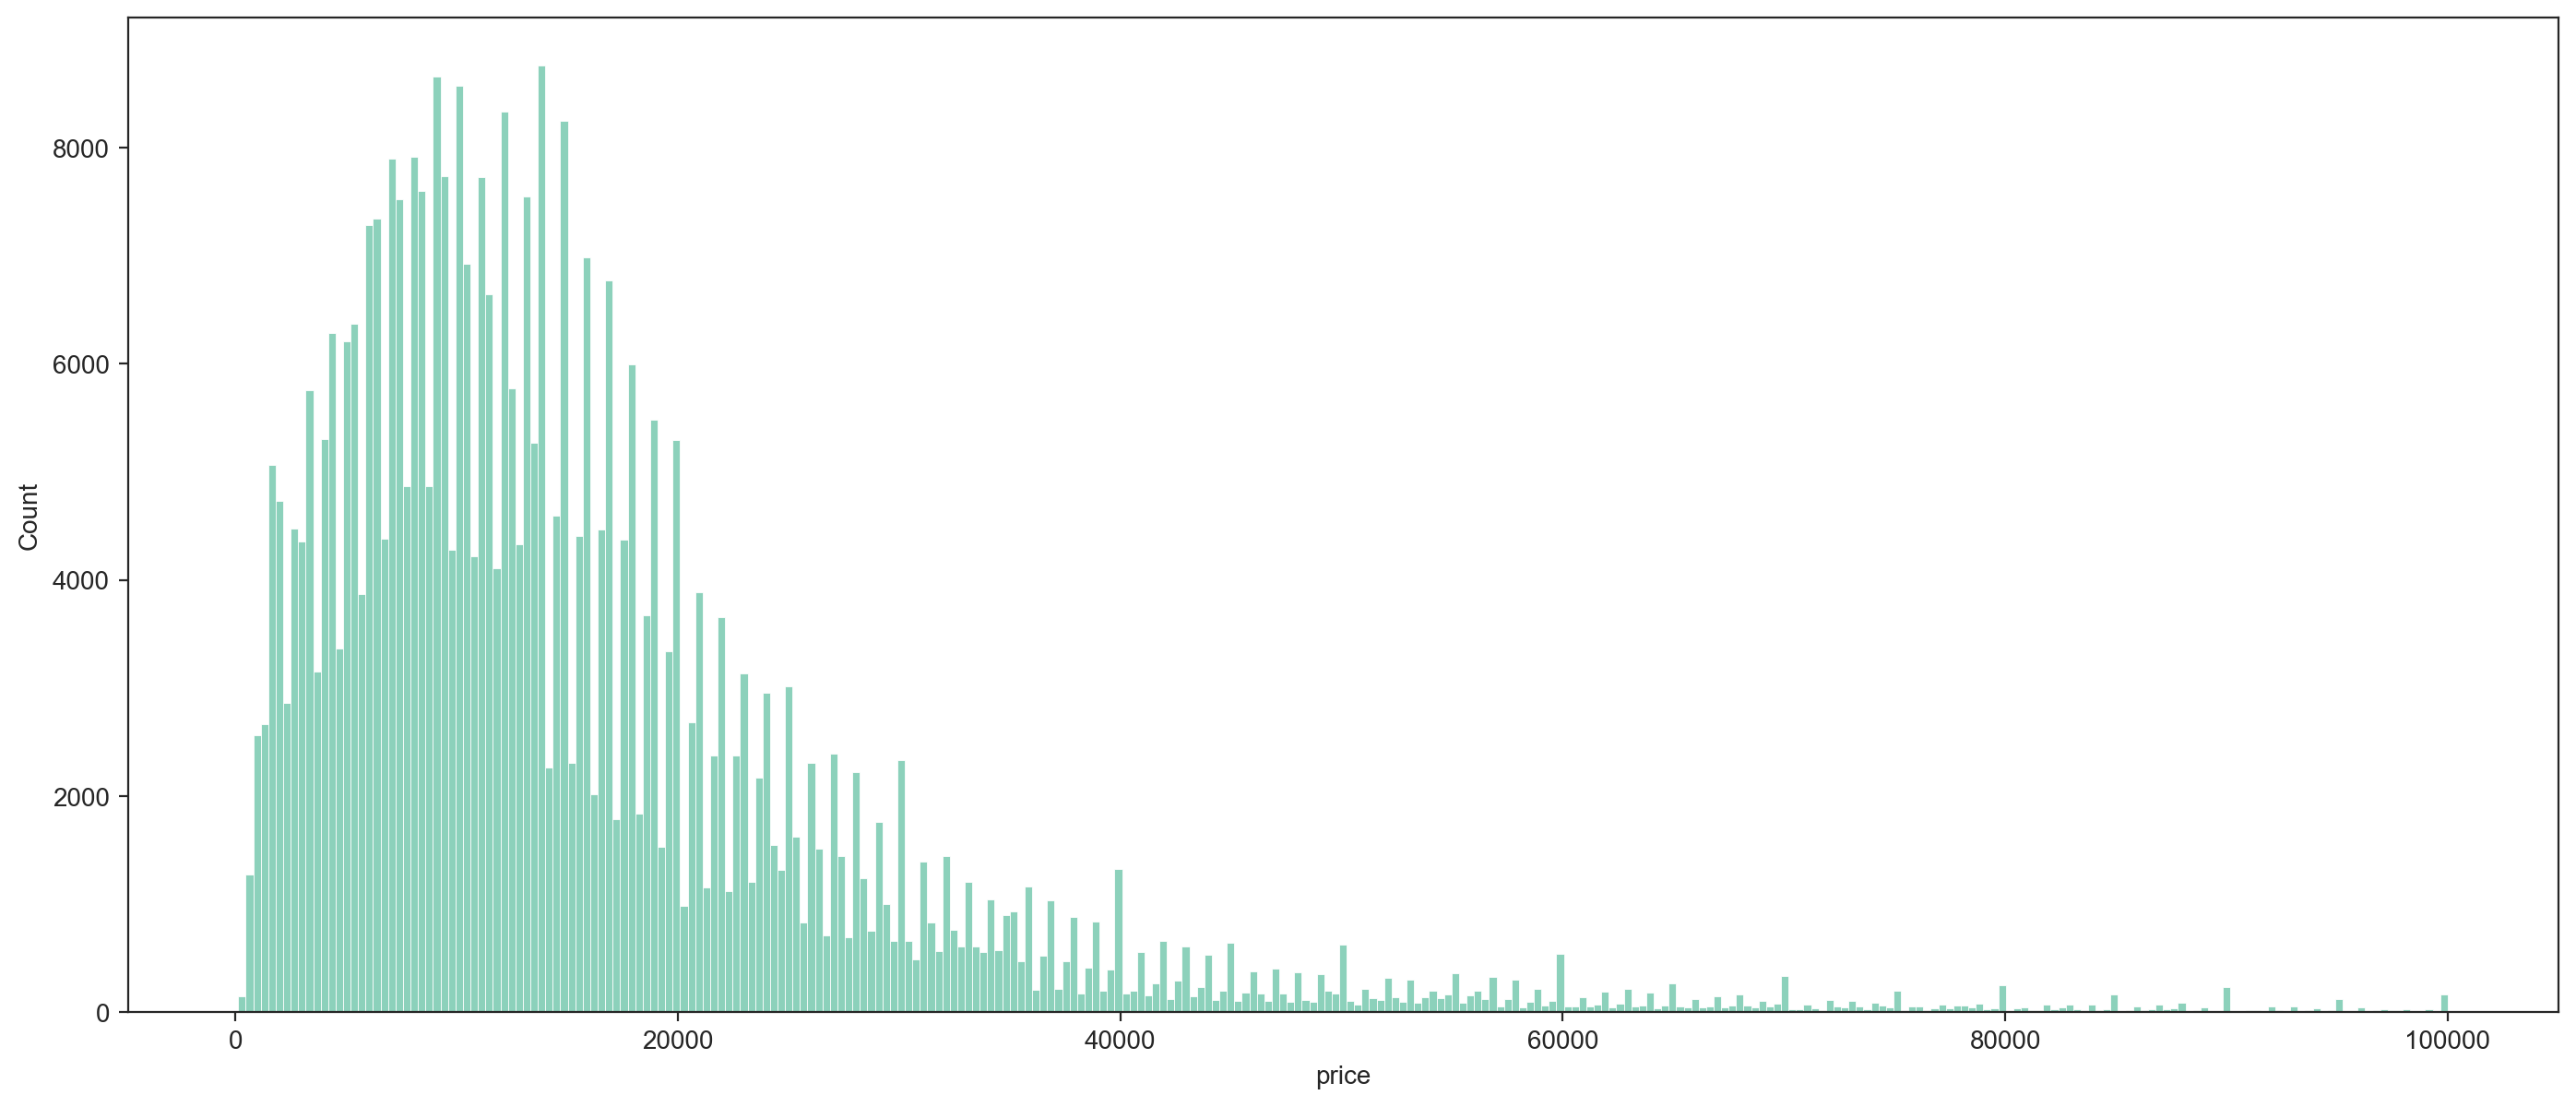

In [245]:
sns.histplot(auto.loc[auto["price"] < 1e5], x="price")

In [246]:
auto.loc[auto["price"]>1e6]

,mileage,reg_code,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,miles_per_day
21997,2180.0,NaN,Bugatti,Veyron,USED,2010.0,1590000.0,Convertible,False,Petrol,0.597260
51741,4400.0,NaN,Bugatti,Veyron,USED,2014.0,2850000.0,Coupe,False,Petrol,2.009132
62571,2200.0,NaN,Porsche,918,USED,2016.0,1099950.0,Convertible,False,Petrol Hybrid,1.506849
64910,189.0,NaN,McLaren,P1,USED,NaN,2695000.0,Coupe,False,Petrol Plug-in Hybrid,NaN
72681,475.0,NaN,Ferrari,LaFerrari,USED,2015.0,2299950.0,Coupe,False,Petrol,0.260274
94033,1900.0,NaN,Pagani,Huayra,USED,NaN,2400000.0,Convertible,False,Petrol,NaN
103974,10895.0,NaN,Bugatti,Veyron,USED,2016.0,1699995.0,Coupe,False,NaN,7.462329
145819,6170.0,NaN,Ferrari,LaFerrari,USED,2013.0,2150000.0,Coupe,False,Petrol Plug-in Hybrid,2.414873
175995,3660.0,NaN,McLaren,P1,USED,2013.0,1200000.0,Coupe,False,Petrol Plug-in Hybrid,1.432485
177165,45.0,1993.0,Porsche,911,USED,1993.0,1395000.0,Coupe,False,Petrol,0.004566


In [241]:
auto["price"].replace(9999999, np.nan, inplace=True)

In [ ]:
for col in auto.columns:
    print(auto[col].unique())

[     0. 108230.   7800. ... 131980. 102289.  53460.]
[  nan 1984. 1991. 2000. 1986. 1998. 2001. 1990. 1992. 1987. 1993. 1994.
 1989. 1999. 1995. 1996. 1983. 1988. 1997. 1985.]
['Volvo' 'Jaguar' 'SKODA' 'Vauxhall' 'Land Rover' 'Audi' 'Mercedes-Benz'
 'Volkswagen' 'Peugeot' 'SEAT' 'MINI' 'BMW' 'Nissan' 'Mitsubishi'
 'Ferrari' 'Citroen' 'Toyota' 'Kia' 'Renault' 'Fiat' 'Honda' 'Bentley'
 'DS AUTOMOBILES' 'Hyundai' 'Aston Martin' 'McLaren' 'Smart' 'Alfa Romeo'
 'Porsche' 'Abarth' 'Mazda' 'Suzuki' 'MG' 'Dacia' 'Subaru' 'SsangYong'
 'Maserati' 'Saab' 'Rolls-Royce' 'Lexus' 'Jeep' 'Panther' 'Chevrolet'
 'Lamborghini' 'Daihatsu' 'Dodge' 'Isuzu' 'Lotus' 'Tesla' 'TVR' 'GMC'
 'Rover' 'Cadillac' 'Infiniti' 'Alpine' 'Chrysler' 'Triumph' 'Morgan'
 'Dax' 'London Taxis International' 'Daimler' 'CUPRA' 'Perodua' 'Lincoln'
 'Bugatti' 'Great Wall' 'Replica' 'Opel' 'AC' 'Proton' 'Lancia' 'Austin'
 'Morris' 'Westfield' 'Maybach' 'Corvette' 'Tiger' 'LEVC' 'Iveco'
 'Caterham' 'Hummer' 'Carbodies' 'Jensen' 'In

In [ ]:
def map_to_int(str_list):
    map_dict = {}
    for i, value in enumerate(str_list):
        map_dict[value] = i
    return map_dict

# Map string values to integers
for column in ["standard_make", "reg_code", "body_type", "fuel_type", "crossover_car_and_van", "vehicle_condition"]:
    mapping_dict = map_to_int(auto[column].unique())                            
    auto[column] = auto[column].replace(to_replace=mapping_dict)


/var/folders/f8/84hgc_1104zb3d1sn2z03zsc0000gn/T/ipykernel_57833/3586677415.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  auto[column] = auto[column].replace(to_replace=mapping_dict)


In [6]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Assuming auto is your DataFrame
# Selecting only the columns that can be imputed by IterativeImputer (numerical or categorical encoded as numbers)
auto_impute = auto.copy()  # Make a copy to avoid altering original data

# Encoding categorical variables if necessary, to numeric, using one-hot encoding or ordinal encoding
# Here is a simple example using Ordinal encoding, but you may prefer other encodings depending on your data characteristics.
from sklearn.preprocessing import OrdinalEncoder

categorical_columns = ['standard_make', 'vehicle_condition', 
                       'body_type', 'crossover_car_and_van', 'fuel_type']
encoder = OrdinalEncoder()
auto_impute[categorical_columns] = encoder.fit_transform(auto[categorical_columns].fillna('missing_value'))

# Initialize IterativeImputer
imputer = IterativeImputer(random_state=0)

# Fit and transform the data with missing values
auto_imputed = imputer.fit_transform(auto_impute)

# Convert the imputed array back to a DataFrame with the original column names
auto_imputed = pd.DataFrame(auto_imputed, columns=auto_impute.columns)

# Optionally, convert categorical columns back to their original format
auto_imputed[categorical_columns] = encoder.inverse_transform(auto_imputed[categorical_columns])

# View the resulting DataFrame with imputed values
auto_imputed.head()

,mileage,reg_code,standard_make,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,0.0,0.0,0,0,2021.586143,73970.0,0,0,0
1,108230.0,1.0,1,1,2011.000000,7000.0,1,0,1
2,7800.0,2.0,2,1,2017.000000,14000.0,0,0,2
3,45000.0,3.0,3,1,2016.000000,7995.0,2,0,1
4,64000.0,4.0,4,1,2015.000000,26995.0,0,0,1


In [7]:
for col in auto.columns:
    print(f"{col} has {auto_imputed[col].isnull().sum()} null values")

mileage has 0 null values
reg_code has 0 null values
standard_make has 0 null values
vehicle_condition has 0 null values
year_of_registration has 0 null values
price has 0 null values
body_type has 0 null values
crossover_car_and_van has 0 null values
fuel_type has 0 null values


In [8]:
auto_imputed.isnull().values.any()

np.False_

In [ ]:
# Remove low variance features

from sklearn.feature_selection import VarianceThreshold

# Instantiate the VarianceThreshold object with a threshold value
threshold = 0.1  # Adjust threshold as needed
selector = VarianceThreshold(threshold)

# Fit the selector to your data
selector.fit(auto)

# Get the indices of features with high variance
high_variance_indices = selector.get_support(indices=True)

# Subset your data with selected features
selected_data = auto.iloc[:, high_variance_indices]

for col in auto.columns:
    if col not in selected_data.columns:
        print("Dropped", col)

selected_data.head()

Dropped vehicle_condition
Dropped crossover_car_and_van
Dropped fuel_type


,mileage,reg_code,standard_make,year_of_registration,price,body_type
0,0.0,0,0,NaN,73970.0,0
1,108230.0,1,1,2011.0,7000.0,1
2,7800.0,2,2,2017.0,14000.0,0
3,45000.0,3,3,2016.0,7995.0,2
4,64000.0,4,4,2015.0,26995.0,0


### Split data for fitting

In [10]:
from sklearn.model_selection import train_test_split

X, y = auto_imputed.drop(columns="price"), auto_imputed["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Regression

### MLP Regressor
(My Little Pony Regressor)

In [11]:
# Normalise input features to values 0-1

from sklearn.preprocessing import StandardScaler  

scaler = StandardScaler() 
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes=(180,120,80),
                       max_iter = 300,activation = 'relu',
                       solver = 'adam')

nn.fit(X_train, y_train)
nn.score(X_train, y_train), nn.score(X_test, y_test)

https://michael-fuchs-python.netlify.app/2021/02/10/nn-multi-layer-perceptron-regressor-mlpregressor/

In [ ]:
y_pred = nn.predict(X_test)
df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_temp.head()

,Actual,Predicted
332044,23000.0,24860.839990
173955,16000.0,15915.264299
367464,4799.0,4974.336713
47695,11000.0,13003.325501
210184,5400.0,6440.238958


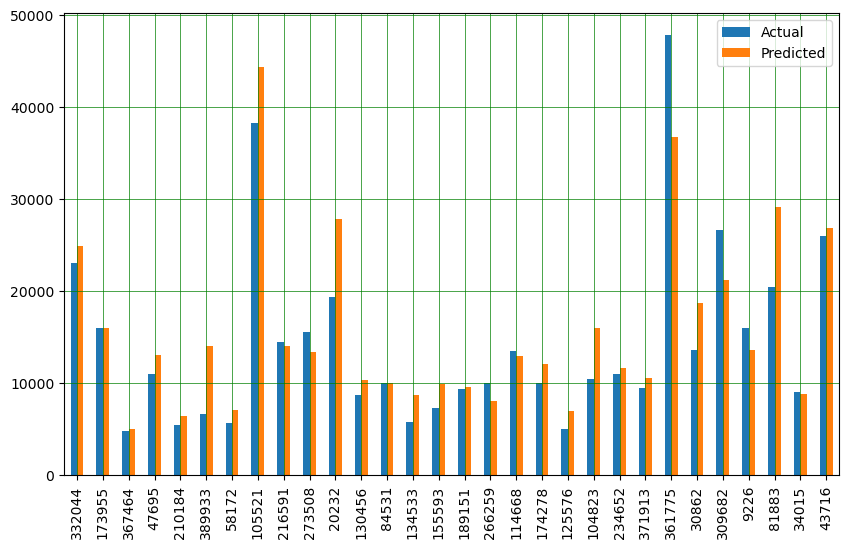

In [ ]:
import matplotlib.pyplot as plt

df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
from sklearn import metrics
import numpy as np

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 4177.2676974313845
Mean Squared Error: 297218113.5196707
Root Mean Squared Error: 17240.01489325548


In [ ]:
param_grid = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [50, 100],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(nn, param_grid, n_jobs= -1, cv=5)
grid.fit(X_train, y_train)

print(grid.best_params_)

KeyboardInterrupt: 

Best Params: 
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}

In [ ]:
grid_predictions = grid.predict(X_test) 

In [ ]:
df_temp2 = pd.DataFrame({'Actual': y_test, 'Predicted': grid_predictions})
df_temp2.head()

,Actual,Predicted
332044,23000.0,20129.801384
173955,16000.0,16715.639034
367464,4799.0,3135.050260
47695,11000.0,12277.705602
210184,5400.0,7190.864910


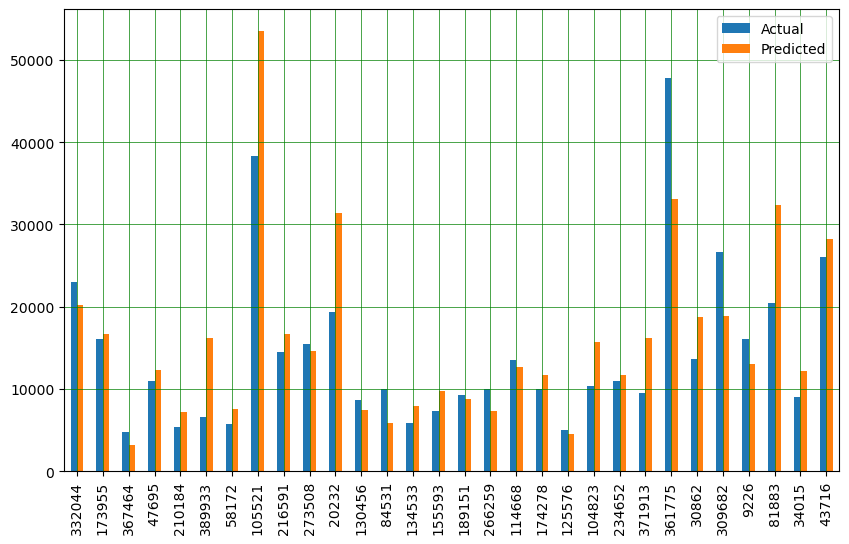

In [ ]:
df_temp2 = df_temp2.head(30)
df_temp2.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, grid_predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, grid_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, grid_predictions)))

Mean Absolute Error: 5177.329648334305
Mean Squared Error: 383942269.40369207
Root Mean Squared Error: 19594.444860819407
